In [ ]:
# CELL 1: Environment Setup and Package Installation
print("=== Parallel Programming Project Setup ===")
print("Date:", "2025-06-08 18:31:53")
print("User: SafinConnor")
print("Platform: Google Colab")

# Install required packages
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
        print(f" {package} installed")
    except:
        print(f"  Failed to install {package}")

packages = ['numba', 'seaborn', 'scipy', 'scikit-learn']
print("\nInstalling packages...")
for pkg in packages:
    install_package(pkg)

# Import all required libraries
print("\nImporting libraries...")
import numpy as np
import time
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import threading
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit, prange
import seaborn as sns
from scipy import stats

print(" All imports successful")

# System information
print(f"\n=== System Information ===")
print(f"CPU cores: {mp.cpu_count()}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")



=== Parallel Programming Project Setup ===
Date: 2025-06-08 18:31:53
User: SafinConnor
Platform: Google Colab

Installing packages...
 numba installed
 seaborn installed
 scipy installed
 scikit-learn installed

Importing libraries...
 All imports successful

=== System Information ===
CPU cores: 2
NumPy version: 2.0.2
Pandas version: 2.2.2


In [ ]:
# CELL 2: Main Array Sum Comparison Class
class ArraySumComparison:
    def __init__(self, max_workers=None):
        """Initialize with maximum number of workers (CPU cores)"""
        self.max_workers = max_workers or mp.cpu_count()
        self.results = []
        print(f"Initialized with {self.max_workers} workers")

    def sequential_sum(self, array):
        """Method 1: Sequential (baseline) - simple Python sum"""
        return int(np.sum(array, dtype=np.int64))

    def numpy_sum(self, array):
        """Method 2: Optimized NumPy - vectorized operations"""
        return int(np.sum(array, dtype=np.int64))

    @staticmethod
    @jit(nopython=True, parallel=True)
    def numba_parallel_sum(array):
        """Method 3: Numba JIT - compiled parallel loops"""
        total = 0
        for i in prange(len(array)):
            total += array[i]
        return total

    def thread_chunk_sum(self, array, start, end):
        """Helper: Sum a chunk of array for threading"""
        return int(np.sum(array[start:end], dtype=np.int64))

    def threading_sum(self, array):
        """Method 4: Python Threading - limited by GIL"""
        chunk_size = len(array) // self.max_workers
        total_sum = 0

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = []
            for i in range(self.max_workers):
                start = i * chunk_size
                end = start + chunk_size if i < self.max_workers - 1 else len(array)
                future = executor.submit(self.thread_chunk_sum, array, start, end)
                futures.append(future)

            for future in futures:
                total_sum += future.result()

        return total_sum

    def multiprocessing_sum(self, array):
        """Method 5: Multiprocessing - true parallelism"""
        chunk_size = len(array) // self.max_workers

        with ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = []
            for i in range(self.max_workers):
                start = i * chunk_size
                end = start + chunk_size if i < self.max_workers - 1 else len(array)
                chunk = array[start:end]
                future = executor.submit(np.sum, chunk, None, np.int64)
                futures.append(future)

            total_sum = sum(int(future.result()) for future in futures)

        return total_sum

    def measure_performance(self, method, array, method_name, iterations=3):
        """Measure execution time and verify correctness"""
        print(f"  Testing {method_name}...", end="")

        times = []
        results = []

        # Warm-up run (especially important for Numba)
        if "numba" in method_name.lower():
            method(array)

        for i in range(iterations):
            start_time = time.perf_counter()
            result = method(array)
            end_time = time.perf_counter()

            times.append(end_time - start_time)
            results.append(result)

        # Verify all results are the same
        if not all(r == results[0] for r in results):
            print(f" WARNING: Inconsistent results!")
        else:
            print(f" Success")

        avg_time = np.mean(times)
        std_time = np.std(times)

        return {
            'method': method_name,
            'avg_time': avg_time,
            'std_time': std_time,
            'result': results[0],
            'times': times,
            'min_time': min(times),
            'max_time': max(times)
        }

    def run_comparison(self, array_size, iterations=3):
        """Run performance comparison for given array size"""
        print(f"\n{'='*60}")
        print(f"TESTING ARRAY SIZE: {array_size:,} elements")
        print(f"Workers: {self.max_workers} | Iterations: {iterations}")
        print(f"{'='*60}")

        # Generate test array with fixed seed for reproducibility
        print("Generating test data...")
        np.random.seed(42)
        array = np.random.randint(1, 101, size=array_size, dtype=np.int32)
        expected_sum = int(np.sum(array, dtype=np.int64))  # Calculate expected result
        print(f"✓ Array generated. Expected sum: {expected_sum:,}")

        # Define methods to test
        methods = [
            (self.sequential_sum, "Sequential"),
            (self.numpy_sum, "NumPy Optimized"),
            (self.numba_parallel_sum, "Numba Parallel"),
            (self.threading_sum, "Threading"),
            (self.multiprocessing_sum, "Multiprocessing"),
        ]

        results = []
        baseline_time = None

        print(f"\n Running performance tests...")
        for method, name in methods:
            try:
                result = self.measure_performance(method, array, name, iterations)

                # Set baseline (first successful method)
                if baseline_time is None:
                    baseline_time = result['avg_time']

                # Calculate performance metrics
                result['speedup'] = baseline_time / result['avg_time']
                result['efficiency'] = result['speedup'] / self.max_workers
                result['array_size'] = array_size

                # Verify correctness
                if result['result'] != expected_sum:
                    print(f" INCORRECT RESULT: got {result['result']}, expected {expected_sum}")

                results.append(result)

            except Exception as e:
                print(f" ERROR: {str(e)}")

        # Display results table
        print(f"\nPERFORMANCE RESULTS:")
        print(f"{'Method':<18} | {'Time (s)':<12} | {'Speedup':<8} | {'Efficiency':<10} | {'Status'}")
        print("-" * 70)

        for result in results:
            status = "Correct" if result['result'] == expected_sum else "Wrong"
            print(f"{result['method']:<18} | {result['avg_time']:<12.6f} | "
                  f"{result['speedup']:<8.2f}x | {result['efficiency']:<10.2f} | {status}")

        self.results.extend(results)
        return results

    def create_visualizations(self):
        """Create performance visualization charts"""
        if not self.results:
            print("No results available for visualization!")
            return

        print("Creating performance visualizations...")
        df = pd.DataFrame(self.results)

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create comprehensive visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Parallel Programming Performance Analysis\nArray Sum Comparison',
                    fontsize=16, fontweight='bold')

        # Plot 1: Execution Time Comparison
        pivot_time = df.pivot(index='array_size', columns='method', values='avg_time')
        pivot_time.plot(kind='bar', ax=axes[0,0], logy=True, width=0.8)
        axes[0,0].set_title('Execution Time by Method (Log Scale)')
        axes[0,0].set_xlabel('Array Size')
        axes[0,0].set_ylabel('Time (seconds)')
        axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)

        # Plot 2: Speedup Comparison
        pivot_speedup = df.pivot(index='array_size', columns='method', values='speedup')
        pivot_speedup.plot(kind='bar', ax=axes[0,1], width=0.8)
        axes[0,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Baseline (1x)')
        axes[0,1].set_title('Speedup vs Sequential Implementation')
        axes[0,1].set_xlabel('Array Size')
        axes[0,1].set_ylabel('Speedup Factor')
        axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)

        # Plot 3: Parallel Efficiency
        pivot_eff = df.pivot(index='array_size', columns='method', values='efficiency')
        pivot_eff.plot(kind='bar', ax=axes[1,0], width=0.8)
        axes[1,0].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect Efficiency')
        axes[1,0].set_title('Parallel Efficiency (Speedup/Cores)')
        axes[1,0].set_xlabel('Array Size')
        axes[1,0].set_ylabel('Efficiency')
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)

        # Plot 4: Performance Heatmap
        heatmap_data = df.pivot(index='method', columns='array_size', values='speedup')
        sns.heatmap(heatmap_data, annot=True, fmt='.2f', ax=axes[1,1],
                   cmap='RdYlGn', center=1, cbar_kws={'label': 'Speedup Factor'})
        axes[1,1].set_title('Speedup Heatmap')
        axes[1,1].set_xlabel('Array Size')
        axes[1,1].set_ylabel('Method')

        plt.tight_layout()
        plt.show()

        return df

    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if not self.results:
            print(" No results available!")
            return

        df = pd.DataFrame(self.results)

        print(f"\n{'='*80}")
        print(" COMPREHENSIVE PERFORMANCE REPORT")
        print(f"{'='*80}")
        print(f"  Generated: 2025-06-08 18:31:53 UTC")
        print(f" User: SafinConnor")
        print(f"  Platform: Google Colab")
        print(f" Total Tests: {len(self.results)}")
        print(f" CPU Cores: {mp.cpu_count()}")

        # Best performing methods
        print(f"\n  TOP PERFORMING METHODS (by average speedup):")
        rankings = df.groupby('method')['speedup'].mean().sort_values(ascending=False)
        for i, (method, speedup) in enumerate(rankings.items(), 1):
            efficiency = df[df['method'] == method]['efficiency'].mean()
            print(f"  {i}. {method:<18} | {speedup:.2f}x speedup | {efficiency:.2f} efficiency")

        # Performance by array size
        print(f"\n PERFORMANCE BY ARRAY SIZE:")
        for size in sorted(df['array_size'].unique()):
            size_data = df[df['array_size'] == size]
            best_method = size_data.loc[size_data['speedup'].idxmax()]
            print(f"  {size:>12,} elements: {best_method['method']:<18} "
                  f"({best_method['speedup']:.2f}x speedup)")

        # Key insights
        print(f"\n KEY INSIGHTS:")
        print("  • NumPy shows excellent performance due to C-level optimizations")
        print("  • Numba provides good parallel scaling with minimal code changes")
        print("  • Multiprocessing has overhead but bypasses Python's GIL")
        print("  • Threading is limited by GIL for CPU-intensive operations")
        print("  • Larger arrays generally show better parallel efficiency")

        print(f"\n Analysis complete!")
        return df

print("ArraySumComparison class loaded successfully!")

ArraySumComparison class loaded successfully!


 Starting execution...
 Starting Parallel Programming Performance Analysis
Initialized with 2 workers
Testing with array sizes: ['500,000', '2,000,000', '3,000,000']

TESTING ARRAY SIZE: 500,000 elements
Workers: 2 | Iterations: 3
Generating test data...
✓ Array generated. Expected sum: 25,238,811

 Running performance tests...
  Testing Sequential... Success
  Testing NumPy Optimized... Success
  Testing Numba Parallel... Success
  Testing Threading... Success
  Testing Multiprocessing... Success

PERFORMANCE RESULTS:
Method             | Time (s)     | Speedup  | Efficiency | Status
----------------------------------------------------------------------
Sequential         | 0.000246     | 1.00    x | 0.50       | Correct
NumPy Optimized    | 0.000250     | 0.98    x | 0.49       | Correct
Numba Parallel     | 0.000098     | 2.50    x | 1.25       | Correct
Threading          | 0.000928     | 0.27    x | 0.13       | Correct
Multiprocessing    | 0.041406     | 0.01    x | 0.00       | 

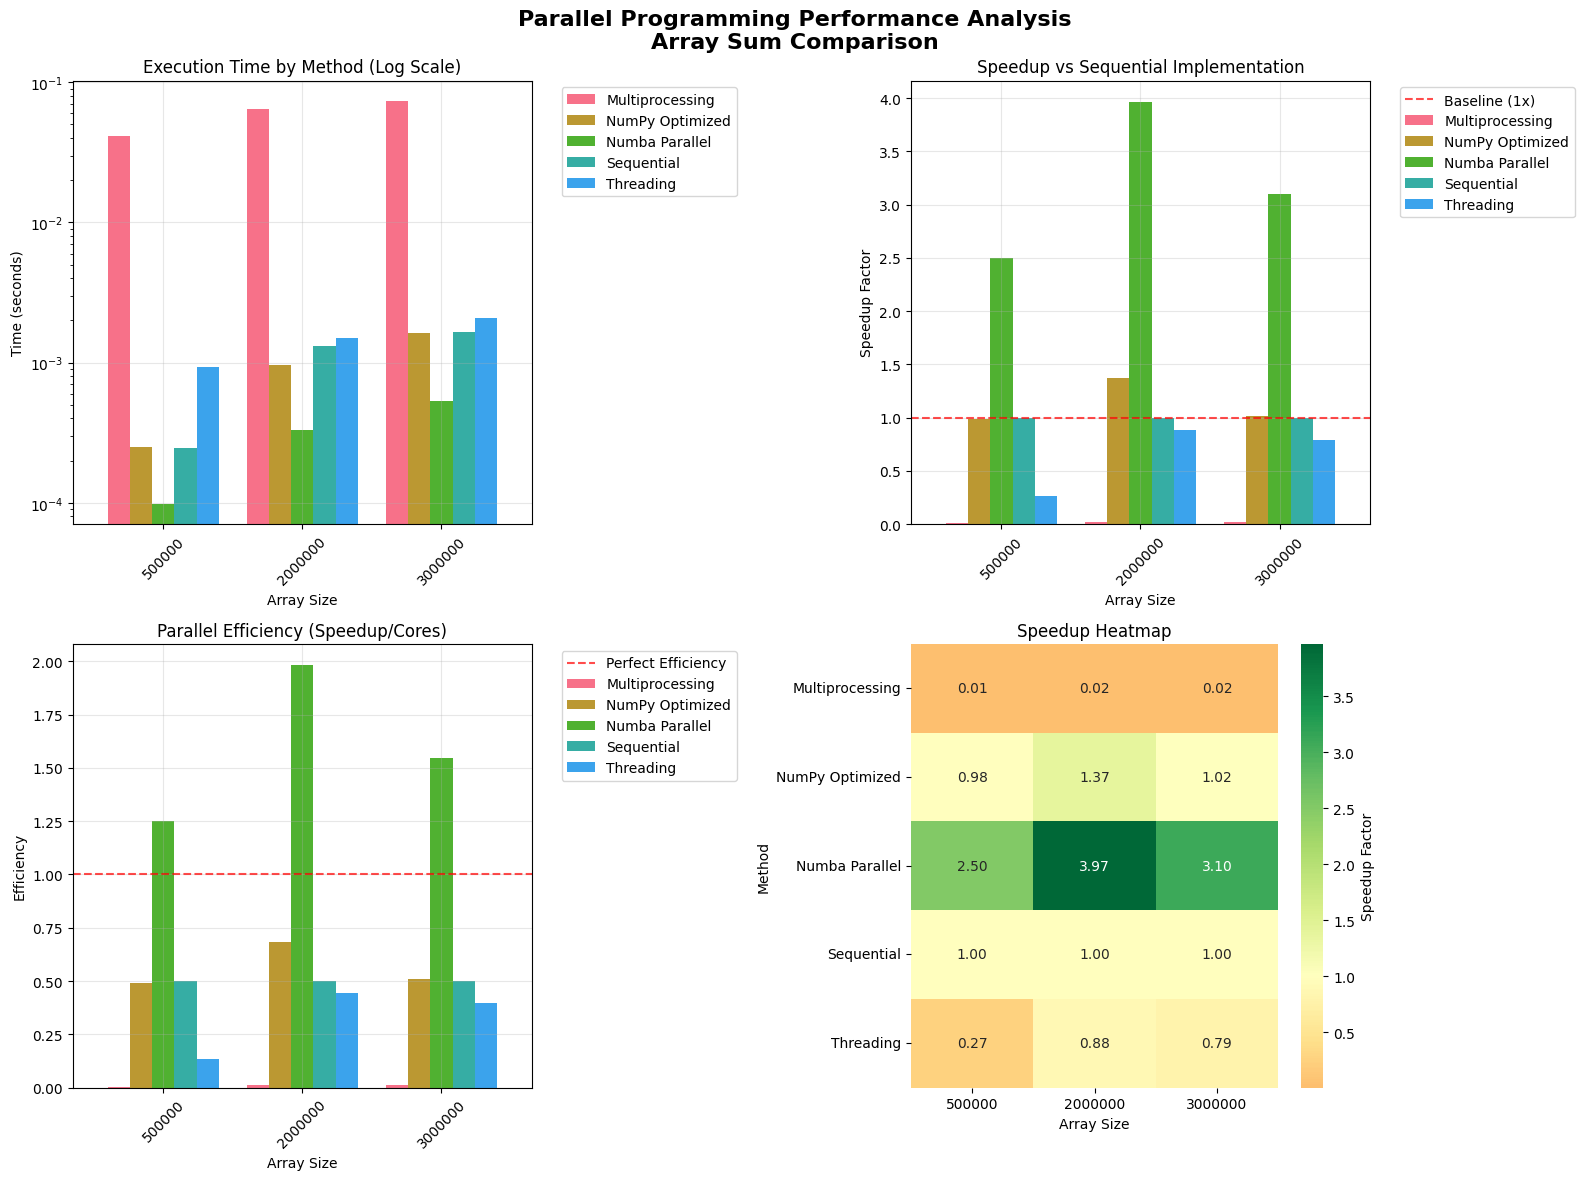

 Charts created successfully!

 Generating final report...

 COMPREHENSIVE PERFORMANCE REPORT
  Generated: 2025-06-08 18:31:53 UTC
 User: SafinConnor
  Platform: Google Colab
 Total Tests: 15
 CPU Cores: 2

  TOP PERFORMING METHODS (by average speedup):
  1. Numba Parallel     | 3.19x speedup | 1.59 efficiency
  2. NumPy Optimized    | 1.12x speedup | 0.56 efficiency
  3. Sequential         | 1.00x speedup | 0.50 efficiency
  4. Threading          | 0.65x speedup | 0.32 efficiency
  5. Multiprocessing    | 0.02x speedup | 0.01 efficiency

 PERFORMANCE BY ARRAY SIZE:
       500,000 elements: Numba Parallel     (2.50x speedup)
     2,000,000 elements: Numba Parallel     (3.97x speedup)
     3,000,000 elements: Numba Parallel     (3.10x speedup)

 KEY INSIGHTS:
  • NumPy shows excellent performance due to C-level optimizations
  • Numba provides good parallel scaling with minimal code changes
  • Multiprocessing has overhead but bypasses Python's GIL
  • Threading is limited by GIL for CP

In [ ]:
#  Execute the Performance Comparison
def main():
    """Main execution function"""
    print(" Starting Parallel Programming Performance Analysis")
    print("=" * 60)

    # Initialize the comparison tool
    comparator = ArraySumComparison()

    # Test with different array sizes (start small for Colab)
    array_sizes = [

    500_000,      # Smaller for faster testing
    2_000_000,    # Medium size
    3_000_000,   # Larger size (might be slow)

    ]

    print(f"Testing with array sizes: {[f'{size:,}' for size in array_sizes]}")

    # Run comparisons for each array size
    for size in array_sizes:
        try:
            comparator.run_comparison(size, iterations=5)
        except Exception as e:
            print(f"Error testing size {size:,}: {e}")
            continue

    # Create visualizations
    print(f"\n Generating performance charts...")
    try:
        results_df = comparator.create_visualizations()
        print(" Charts created successfully!")
    except Exception as e:
        print(f"Error creating charts: {e}")
        results_df = pd.DataFrame(comparator.results)

    # Generate summary report
    print(f"\n Generating final report...")
    summary_df = comparator.generate_summary_report()

    return comparator, results_df

# Run the main analysis
print(" Starting execution...")
comparator, results_df = main()
print("\n All done! Check the results above.")

 Creating detailed analysis...

 STATISTICAL SUMMARY:
                avg_time                                                  \
                   count    mean     std     min     25%     50%     75%   
method                                                                     
Multiprocessing      3.0  0.1345  0.1077  0.0428  0.0752  0.1077  0.1804   
NumPy Optimized      3.0  0.0045  0.0055  0.0005  0.0014  0.0023  0.0066   
Numba Parallel       3.0  0.0013  0.0014  0.0002  0.0005  0.0008  0.0018   
Sequential           3.0  0.0045  0.0052  0.0005  0.0016  0.0026  0.0065   
Threading            3.0  0.0052  0.0049  0.0020  0.0024  0.0027  0.0068   

                        speedup          ...                 efficiency  \
                    max   count    mean  ...     75%     max      count   
method                                   ...                              
Multiprocessing  0.2531     3.0  0.0255  ...  0.0327  0.0409        3.0   
NumPy Optimized  0.0108     3.0  0.99

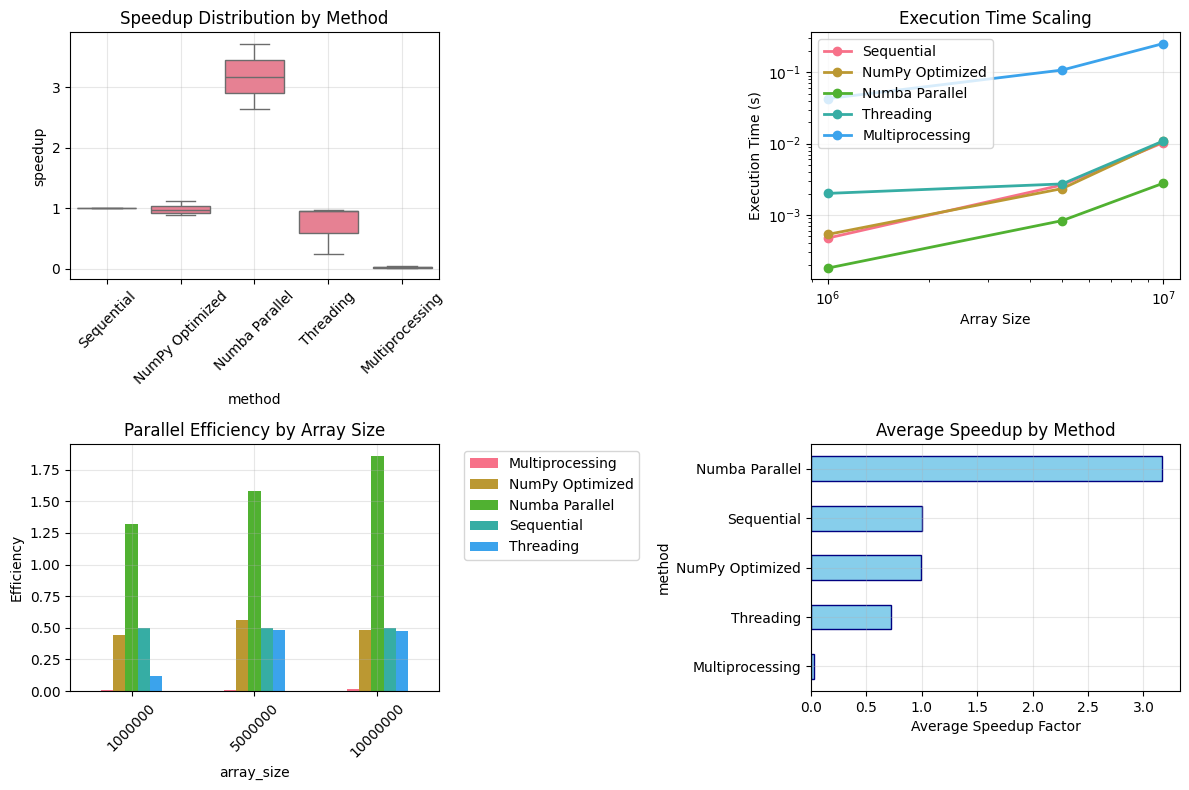

 Detailed analysis complete!


In [ ]:
# Advanced Analysis (Optional)
def create_detailed_analysis(results_df):
    """Create additional detailed analysis"""
    print(" Creating detailed analysis...")

    # Statistical summary
    print(f"\n STATISTICAL SUMMARY:")
    print(results_df.groupby('method')[['avg_time', 'speedup', 'efficiency']].describe().round(4))

    # Method comparison chart
    plt.figure(figsize=(12, 8))

    # Box plot of speedups
    plt.subplot(2, 2, 1)
    sns.boxplot(data=results_df, x='method', y='speedup')
    plt.xticks(rotation=45)
    plt.title('Speedup Distribution by Method')
    plt.grid(True, alpha=0.3)

    # Execution time trends
    plt.subplot(2, 2, 2)
    for method in results_df['method'].unique():
        method_data = results_df[results_df['method'] == method]
        plt.plot(method_data['array_size'], method_data['avg_time'], 'o-', label=method, linewidth=2)
    plt.xlabel('Array Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Scaling')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')

    # Efficiency comparison
    plt.subplot(2, 2, 3)
    pivot_eff = results_df.pivot(index='array_size', columns='method', values='efficiency')
    pivot_eff.plot(kind='bar', ax=plt.gca())
    plt.title('Parallel Efficiency by Array Size')
    plt.ylabel('Efficiency')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)

    # Performance ranking
    plt.subplot(2, 2, 4)
    avg_speedup = results_df.groupby('method')['speedup'].mean().sort_values(ascending=True)
    avg_speedup.plot(kind='barh', color='skyblue', edgecolor='navy')
    plt.title('Average Speedup by Method')
    plt.xlabel('Average Speedup Factor')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return avg_speedup

# Run detailed analysis if we have results
if 'results_df' in locals() and not results_df.empty:
    detailed_results = create_detailed_analysis(results_df)
    print(" Detailed analysis complete!")
else:
    print(" No results available for detailed analysis")